In this notebook, we're going to talk about the various methods that people use to keep track of ***timestamps***. A timestamp refers to the time at which a measurement was taken during a series of events.


# Important: Run this code cell each time you start a new session!

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install ipywidgets
!pip install os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.5 MB/s eta 0:00:00


In [ ]:
!wget -Ncnp https://physionet.org/files/accelerometry-walk-climb-drive/1.0.0/raw_accelerometry_data/id00b70b13.csv

--2023-07-04 14:44:51--  https://physionet.org/files/accelerometry-walk-climb-drive/1.0.0/raw_accelerometry_data/id00b70b13.csv
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25931775 (25M) [text/plain]
Saving to: ‘id00b70b13.csv’

id00b70b13.csv      100%[===================>]  24.73M   681KB/s    in 37s     

2023-07-04 14:45:28 (687 KB/s) - ‘id00b70b13.csv’ saved [25931775/25931775]



In [ ]:
df = pd.read_csv('id00b70b13.csv')

# Filter to only walking activity, which is given a code of 1
df = df[df['activity'] == 1]

# Process the time
df.rename(columns={'time_s': 'Time'}, inplace=True)
df = df[(df['Time']>=700) & (df['Time']<=710)]
df['Time'] = df['Time'] - df['Time'].min()

# Process the accel
df['Accel'] = np.sqrt(df['la_x']**2 + df['la_y']**2 + df['la_z']**2)*9.8

# Keep only crucial columns
keep_cols = ['Time', 'Accel']
df = df[keep_cols]
df.to_csv('walking.csv',index=False)

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


# Option 1: `ints` and `floats`

The simplest way of including a timestamp is by using integers or floats to represent a unit of time like milliseconds, minutes, or hours. In some cases, the sequence starts from 0 and increments until measurements stop being recorded. The `Time` column of the following time series does just that, showing how much time has passed since the start of the recording in seconds:

In [ ]:
df = pd.read_csv('walking.csv')
df.head(10)

,Time,Accel
0,0.00,10.300098
1,0.01,10.340338
2,0.02,10.302858
3,0.03,10.185373
4,0.04,10.418875
5,0.05,9.997921
6,0.06,10.396738
7,0.07,10.681087
8,0.08,11.111100
9,0.09,12.580975


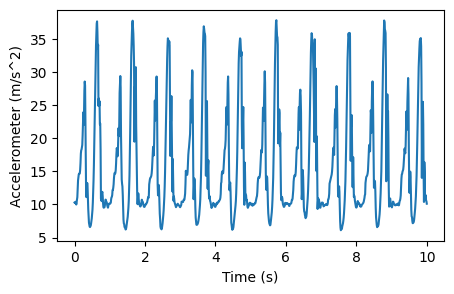

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(df['Time'], df['Accel'])
plt.xlabel('Time (s)')
plt.ylabel('Accelerometer (m/s^2)')
plt.show()

# Option 2: Unix Time

Many computers will keep track of time using a measurement system known as ***Unix time***, which measures the number of seconds that have elapsed since `00:00:00 UTC on 1 January 1970`. You can get the current Unix time using the `time` library:

In [ ]:
# Get the current time
import time
time.time()

1688482114.2652555


If we were to pretend that the previous signal was recorded with a device using Unix time, it would have looked something like the following:

In [ ]:
# Manipulate the timestamps so they start at the current time
df = pd.read_csv('walking.csv')
df['Time'] = df['Time'] + time.time()
df.head(10)

,Time,Accel
0,1.688487e+09,10.300098
1,1.688487e+09,10.340338
2,1.688487e+09,10.302858
3,1.688487e+09,10.185373
4,1.688487e+09,10.418875
5,1.688487e+09,9.997921
6,1.688487e+09,10.396738
7,1.688487e+09,10.681087
8,1.688487e+09,11.111100
9,1.688487e+09,12.580975


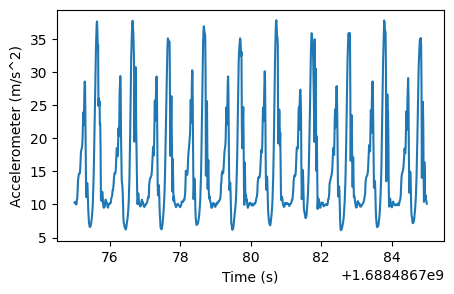

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(df['Time'], df['Accel'])
plt.xlabel('Time (s)')
plt.ylabel('Accelerometer (m/s^2)')
plt.show()

Notice that it is not as easy to make meaning of the horizontal axis in our graph when we use Unix time. Unless the exact time at which the data was recorded is important, you will often want to standardize your timestamp sequences so that they start at 0. This will not only make your graphs more readable, but also allow you to easily access data that satisfies constraints such as "the first 5 minutes of data" or "the third survey response after the study participant joined the protocol".

Standardizing the timestamp is as simple as subtracting the earliest timestamp from every timestamp in the sequence.

In [ ]:
df['Time'] = df['Time'] - df['Time'].min()
df.head(10)

,Time,Accel
0,0.00,10.300098
1,0.01,10.340338
2,0.02,10.302858
3,0.03,10.185373
4,0.04,10.418875
5,0.05,9.997921
6,0.06,10.396738
7,0.07,10.681087
8,0.08,11.111100
9,0.09,12.580975


# Option 3: `datetime`

For situations when it is important to keep track of the exact date when a measurement was taken, one option is to use Python's built-in `datetime` object.

In [ ]:
# Get the current time
from datetime import datetime
datetime.now()

datetime.datetime(2023, 7, 4, 17, 53, 0, 613300)

In [ ]:
# Create a timestamp for a specific date and time
datetime.datetime(2022, 9, 1, 12, 0, 0)  # September 1, 2022, 12:00 PM

datetime.datetime(2022, 9, 1, 12, 0)

This data structure allows you to easily extract the specific characteristics of a given date, such as the year, minute, or even microsecond:



In [ ]:
current_time = datetime.now()
print(f"Current year: {current_time.year}")
print(f"Current minute: {current_time.minute}")
print(f"Current microsecond: {current_time.microsecond}")

Current year: 2023
Current minute: 44
Current microsecond: 322204


Most of the plotting functions in `matplotlib` are not designed to handle dates by default. One way to plot time-series data with dates along the horizontal axis is by using the `plot_date()` function.

In [ ]:
# Manipulate the timestamps so they start at the current time
from datetime import timedelta
df = pd.read_csv('walking.csv')
current_time = datetime.now()
df['Date'] = df['Time'].apply(lambda t: current_time + timedelta(seconds=t))
df.head(10)

,Time,Accel,Date
0,0.00,10.300098,2023-07-04 16:16:33.354395
1,0.01,10.340338,2023-07-04 16:16:33.364395
2,0.02,10.302858,2023-07-04 16:16:33.374395
3,0.03,10.185373,2023-07-04 16:16:33.384395
4,0.04,10.418875,2023-07-04 16:16:33.394395
5,0.05,9.997921,2023-07-04 16:16:33.404395
6,0.06,10.396738,2023-07-04 16:16:33.414395
7,0.07,10.681087,2023-07-04 16:16:33.424395
8,0.08,11.111100,2023-07-04 16:16:33.434395
9,0.09,12.580975,2023-07-04 16:16:33.444395


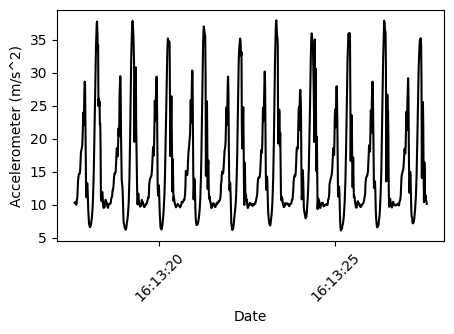

In [ ]:
plt.figure(figsize=(5,3))
plt.plot_date(df['Date'], df['Accel'], 'k-')
plt.xlabel('Date')
plt.ylabel('Accelerometer (m/s^2)')
plt.xticks(rotation=45)
plt.show()

You can also switch between `datetimes` and Unix time as follows:

In [ ]:
# datetime to Unix time
current_time = datetime.now()
current_time.timestamp()

1688485588.298991

In [ ]:
# Unix time to datetime
current_time = time.time()
datetime.fromtimestamp(current_time)

datetime.datetime(2023, 7, 4, 15, 46, 25, 313407)

# Option 4: `Timestamp` in `pandas`

`pandas` provides powerful functionality to automatically infer dates from strings. Dates are technically converted into a bespoke data type in `pandas` called `Timestamp`, but is functionally similar to the `datetime` object in Python.

In the example below, we create a `DataFrame` using our own formatted string. By using the `to_datetime()` function, `pandas` automatically infers which parts of the string correspond to the year, month, etc.

In [ ]:
# Check the current data type of each column
frame_dict = {'Date': ['Jan-01-2023 12:00', 'Jan-02-2023 1:00', 'Jan-03-2023 2:00', 'Jan-04-2023 3:00'],
              'Value': [45, 34, 23, 12]}
df = pd.DataFrame(frame_dict)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    4 non-null      object
 1   Value   4 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 192.0+ bytes


In [ ]:
# Convert the data type of the Date column to a datetime
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4 non-null      datetime64[ns]
 1   Value   4 non-null      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 192.0 bytes


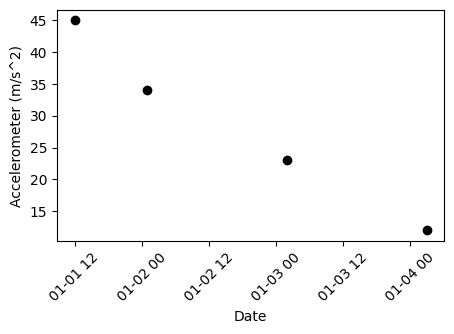

In [ ]:
plt.figure(figsize=(5,3))
plt.plot_date(df['Date'], df['Value'], 'ko')
plt.xlabel('Date')
plt.ylabel('Accelerometer (m/s^2)')
plt.xticks(rotation=45)
plt.show()

When you load data from a .csv file, you can automatically suggest that certain columns are parsed as dates by setting the `infer_datetime_format` argument to `True` and specifying the columns that should be parsed using the `parse_dates` argument

In [ ]:
df = pd.read_csv('walking.csv', parse_dates=['Time'], infer_datetime_format=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    1001 non-null   object 
 1   Accel   1001 non-null   float64
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


In this case, our dates are underspecified since a single `int` could imply any measurement unit of time, so it remains as a string. However, this technique will work for most columns that contain readily identifiable dates.

# Storing Timestamps in `pandas`

In all of the examples above, we have stored timestamps in a `DataFrame` column. Since timestamps are typically unique (i.e., there is one data point per timestamp), you can also use timestamps as the index of a `Series` or a `DataFrame`.

In [ ]:
df = pd.read_csv('walking.csv')
df.set_index('Time', inplace=True)
df.head(10)

,Accel
Time,
0.00,10.300098
0.01,10.340338
0.02,10.302858
0.03,10.185373
0.04,10.418875
0.05,9.997921
0.06,10.396738
0.07,10.681087
0.08,11.111100


There are minor tradeoffs to each approach and some functions may only be compatible with one format of data. We will generally keep timestamps in a column so that we can reference them by name just like any other column.